In [1]:
import numpy as np
import pandas as pd

import json

import seaborn as sns

#!pip install folium
import folium

In [2]:
from source.twarc_hashtags_and_emojis import *
from source.plots_functions import *

#### Functions

#### Exercise 1. 
Using the full activity file of your politicians, obtain the most popular hashtags and present the top 10 in a bar plot using python.

#### Exercise 4. 
Repeat exercise 1 for the dataset that you obtained about Miami beach. What was going on in Miami those days?

In [18]:
# Download the data of Miami with the correct query
!twarc2 search --archive --start-time "2019-03-29" --end-time "2019-03-31" "point_radius:[-80.1709 25.7423 3.11mi]" files/miami.jsonl
!twarc2 csv files/miami.jsonl files/miami.csv

100%|██████████████| Processed 3.45M/3.45M of input file [00:01<00:00, 3.46MB/s]

ℹ️
Parsed 1436 tweets objects from 15 lines in the input file.
Wrote 1436 rows and output 74 columns in the CSV.



In [3]:
# Load the data into pandas df
miami_df = pd.read_csv("files/miami.csv")
miami_df[miami_df.columns[pd.Series(miami_df.columns).str.startswith('geo')]].head()

,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type
0,"[-80.18541, 25.77161]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
1,NaN,NaN,Estados Unidos,US,Marlins Park,"[-80.22144846000792, 25.778580385989454, -80.2...",Feature,07d9d339c4084000,Marlins Park,07d9d339c4084000,poi
2,"[-80.192, 25.7752]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
3,"[-80.18997042, 25.7584841]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
4,"[-80.16957, 25.7767103]",Point,Estados Unidos,US,"Florida, USA","[-87.634643, 24.396308, -79.974307, 31.001056]",Feature,4ec01c9dbc693497,Florida,4ec01c9dbc693497,admin


In [4]:
# Retrieve the hashtags using the function
hashtags_miami = pd.DataFrame(list(hash_retrieve(miami_df)), columns=['hashtag', 'id'])
print(hashtags_miami.shape)
hashtags_miami.head()

(3729, 2)


,hashtag,id
0,JuntosMiami,1112142361734402049
1,Bad,1112140795904036864
2,Enough,1112140795904036864
3,When,1112140795904036864
4,You,1112140795904036864


In [12]:
# Top 10 hasgtags df
hashtags_miami["hashtag"] = hashtags_miami["hashtag"].str.lower() # Convert everything to lowercase 
top10_miami = hashtags_miami['hashtag'].value_counts()[:10].to_frame().reset_index()

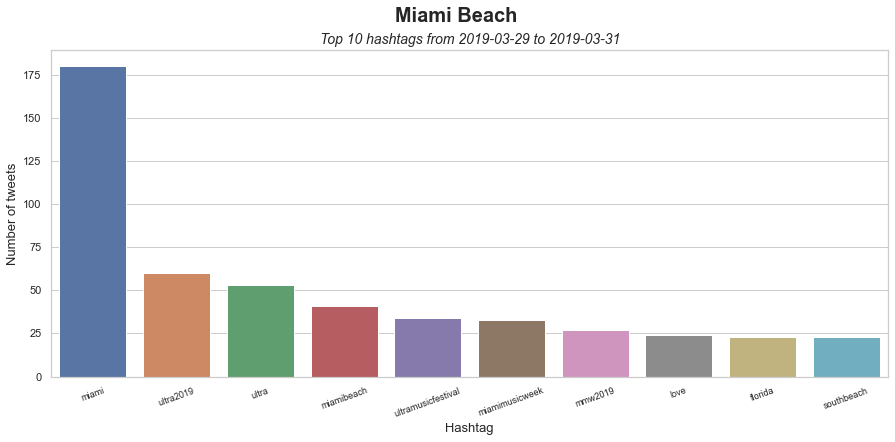

In [13]:
# Plot
bar_plots("index", "hashtag", top10_miami, "Top 10 hashtags from 2019-03-29 to 2019-03-31", "Miami Beach", "Hashtag", "Number of tweets")


#### Exercise 5. 
Using Miami’s dataset, complete the following function (preferably using python) using python:

In [ ]:
def map_tweets (df , center_coords , filename ):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """

In [142]:
# Function
def map_tweets(df , center_coords, filename):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """
    df2 = df.copy() # Copying the data frame
    df2 = df2.dropna(axis = 0, subset = ["geo.coordinates.coordinates"]) # Drop the rows without coordinates

    latitud = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[1]) # Get latitud
    longitude = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[0]) # Get longitude

    # Print a map centered at Miami
    miami_map = folium.Map(location=center_coords, zoom_start=12)

    # Looping over each row (point) to add it in the map 
    for point in latitud.index:
        folium.CircleMarker(location=[latitud[point], longitude[point]], radius=2, color = 'red', fill_color = 'red').add_to(miami_map)
        
    miami_map.save(filename) # Save the map

    return miami_map

In [143]:
# Test
map_tweets(miami_df , [25.7423, -80.1709], 'files/miami_tweets_map.html')